#### Planar data classification with one hidden layer
    Welcome to your week 3 programming assignment! 
    
    It's time to build your first neural network, which will have one hidden layer. Now, you'll notice a big difference between this model and the one you implemented previously using logistic regression.

    By the end of this assignment, you'll be able to:

            - Implement a 2-class classification neural network with a single hidden layer
            - Use units with a non-linear activation function, such as tanh
            - Compute the cross entropy loss
            - Implement forward and backward propagation

**Table of Contents**
- 1 - Packages
- 2 - Load the Dataset
    - Exercise 1
- 3 - Simple Logistic Regression
- 4 - Neural Network model
    - 4.1 - Defining the neural network structure
        - Exercise 2 - layer_sizes
    - 4.2 - Initialize the model's parameters
        - Exercise 3 - initialize_parameters
    - 4.3 - The Loop
        - Exercise 4 - forward_propagation
    - 4.4 - Compute the Cost
        - Exercise 5 - compute_cost
    - 4.5 - Implement Backpropagation
        - Exercise 6 - backward_propagation
    - 4.6 - Update Parameters
        - Exercise 7 - update_parameters
    - 4.7 - Integration
        - Exercise 8 - nn_model
- 5 - Test the Model
    - 5.1 - Predict
        - Exercise 9 - predict
    - 5.2 - Test the Model on the Planar Dataset
- 6 - Tuning hidden layer size (optional/ungraded exercise)
- 7- Performance on other datasets

### 1 - Packages
First import all the packages that you will need during this assignment.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.datasets import make_classification, make_blobs, make_moons, make_gaussian_quantiles
import copy

### 2 - Load the Dataset
    We will load the artificially created dataset which we are calling here planar dataset that has flower like structure. We will use this dataset once we build our neural network model

In [65]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 #no. of examples
    n = 2 #no. of features - dimensionality
    classes = 2 # binary classification
    N = int(m/2) # number of points per class. equally sampled classes
    X = np.zeros((m, n)) #We first create dataset using the usual shape. Later we transpose it when sending to DNN
    y = np.zeros((m, 1), dtype="uint8") # a column vector cuz each example is a row vector here usually - labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower
    
    #lets populate the X and y values
    for j in range(2):
        idx = range(N*j, N*(j+1)) #1st iteration (0, 200) second iteration (200, 400)
        #polar coordinates
        t = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N) * 0.2 #theta
        r = a * np.sin(4*t) + np.random.randn(N) * 0.2 #radius
        X[idx] = np.c_[r * np.sin(t), r * np.cos(t)] # cartesian coordinates = r * sin(angle) , r*cos(angle) to get the vectors or points
        #check mathisfun to understand getting the cartesian coordinates from polar coordindates
        y[idx] = j
        
    #transposing
    X = X.T
    y = y.T
    return X, y

X, y = load_planar_dataset()

    You have: - a numpy-array (matrix) X that contains your features (x1, x2) - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

    First, get a better sense of what your data is like.
    
##### Exercise 1
    How many training examples do you have? In addition, what is the shape of the variables X and Y?

In [70]:
print("X shape" +str(X.shape))
print("Y shape" +str(y.shape))
print(f"Proportion of class 1:  {(sum(y[0, :]) / y.shape[1])}")
print(f"Proportion of class 0:  {1 - (sum(y[0, :]) / y.shape[1])}")

m = y.shape[1]
print ("I have m = %d training examples!" % (m))

X shape(2, 400)
Y shape(1, 400)
Proportion of class 1:  0.5
Proportion of class 0:  0.5
I have m = 400 training examples!


    Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

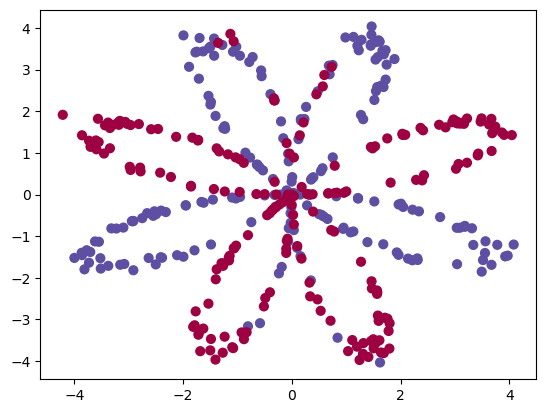

In [67]:
#plot the data
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral_r)
plt.show()

#### 3 - Simple Logistic Regression
    Before building a full neural network, let's check how logistic regression performs on this problem. You can use sklearn's built-in functions for this. Run the code below to train a logistic regression classifier on the dataset.

In [110]:
logistic_model = LogisticRegressionCV()
logistic_model.fit(X.T, y.T.ravel()) #scikit logistic regression expects y to be 1d array, also retransposing to send the usual format

LogisticRegressionCV()

In [410]:
#plot the decision boundary by logistic model using the learned parameters via model predict
def plot_decision_boundary(model, X, y):
    #creating X and y spaces. Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel("x2")
    plt.xlabel("x1")
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

    You can now plot the decision boundary of these models!

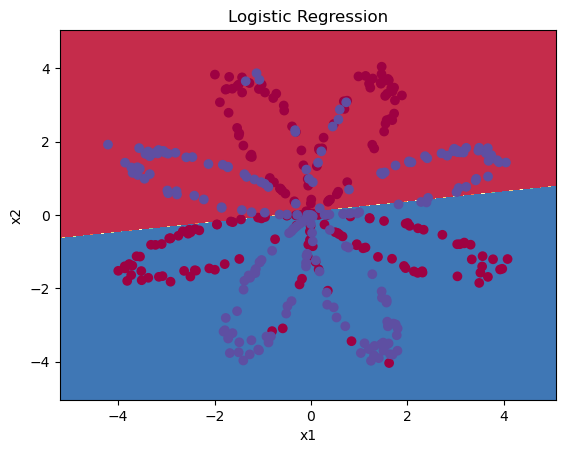

In [411]:
# Plot the decision boundary for logistic regression
predict = lambda x: logistic_model.predict(x)

plot_decision_boundary(predict, X, y)
plt.title("Logistic Regression")
plt.show()

In [131]:
# Print accuracy using cross entropy loss
logistic_preds = logistic_model.predict(X.T)
print("LG's Training accuracy %d" % float( ((np.dot(y, logistic_preds) + np.dot(1-y, 1-logistic_preds)) / float(y.size)) * 100)+
      "%" + " (percentage of correctly labelled datapoints)")

LG's Training accuracy 47% (percentage of correctly labelled datapoints)


    Interpretation: 
        The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now!

### 4 - Neural Network model
    Logistic regression didn't work well on the flower dataset. Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

#### The model:
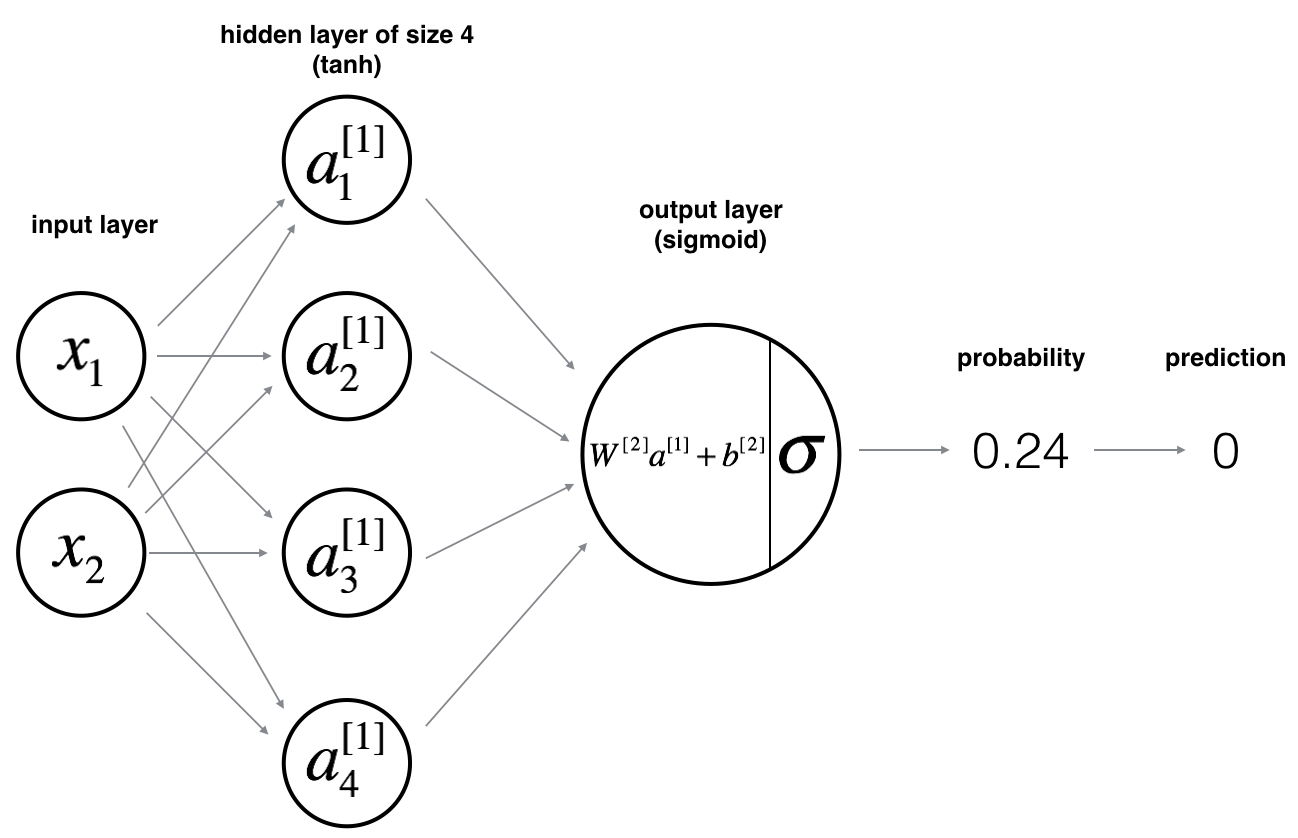

Mathematically for forward propagation:

For one example $x^{(i)}$:

$Z^{[1](i)} = W^{[1]}. x^{(i)} + b^{[1]} = W^{[1]}. a^{[0](i)} + b^{[1]} $

$A^{[1](i)} = tanh(Z^{[1](i)})$

$Z^{[2](i)} = W^{[2]}. A^{[1](i)} + b^{[2]}  $

$A^{[2](i)} = σ{(Z^{[2](i)})} $

$ y^{(i)}_{prediction}$  is

{1 if $x^{(i)} > 0.5$
                           
{0 otherwise

Note: shapes at any layer would be W = (n_out, n_in), A = (n_out, m), b=(n_out, 1)

Given the predictions on all the examples, you can also compute the cost J as follows:
        
J = $ - 1/m  Σ_{i=0}^{m} (y^{(i)} log (a^{[2](i)}) + (1- y^{(i)}) log (1- a^{[2](i)}))$



    Reminder: The general methodology to build a Neural Network is to: 
        1. Define the neural network structure ( # of input units, # of hidden units, etc). 
        2. Initialize the model's parameters 
        3. Loop:
            - Implement forward propagation 
            - Compute loss 
            - Implement backward propagation to get the gradients 
            - Update parameters (gradient descent)


    In practice, you'll often build helper functions to compute steps 1-3, then merge them into one function called nn_model(). Once you've built nn_model() and learned the right parameters, you can make predictions on new data.
    
#### 4.1 - Defining the neural network structure

###### Exercise 2 - layer_sizes
    Define three variables: 
        - n_x: the size of the input layer 
        - n_h: the size of the hidden layer (set this to 4, only for this Exercise 2) 
        - n_y: the size of the output layer

    Hint: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [314]:
def layer_sizes(X, y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = y.shape[0]
    return (n_x, n_h, n_y)

In [135]:
#test the layer_sizes function by getting dummy X and Y's
def layer_size_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3) #5 columns, 3 examples
    Y_assess = np.random.randn(2, 3) # 2 types of labels for 3 examples. Ideally it should be (1, 3)
    return X_assess, Y_assess

t_X, t_Y = layer_size_test_case()
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


#### 4.2 - Initialize the model's parameters

##### Exercise 3 - initialize_parameters
    Implement the function initialize_parameters().

    Instructions:
        - Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
        - You will initialize the weights matrices with random values.
            Use: np.random.randn(a, b) * 0.01 to randomly initialize a matrix of shape (a, b).
        - You will initialize the bias vectors as zeros.
        Use: np.zeros((a, b)) to initialize a matrix of shape (a, b) with zeros.

In [315]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    W_1 = np.random.randn(n_h, n_x) * 0.01
    b_1 = np.zeros((n_h, 1))
    W_2 = np.random.randn(n_y, n_h) * 0.01
    b_2 = np.zeros((n_y, 1))
    params = {
        "W1" : W_1,
        "b1" : b_1,
        "W2" : W_2,
        "b2" : b_2
    }
    return params

In [150]:
#test the initialize_parameters function
np.random.seed(2)
def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y

n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


#### 4.3 - The Loop

##### Exercise 4 - forward_propagation
    Implement forward_propagation() using the following equations:

$Z^{[1]} = W^{[1]}. X + b^{[1]} = W^{[1]}. a^{[0]} + b^{[1]} $

$A^{[1]} = tanh(Z^{[1]})$

$Z^{[2]} = W^{[2]}. A^{[1]} + b^{[2]}  $

$A^{[2]} = σ{(Z^{[2]})} = \hat {Y} $
 
 
    Instructions:

        - Check the mathematical representation of your classifier in the figure above.
        - Use the function sigmoid()
        - Use the function np.tanh(). It's part of the numpy library.
        
    Implement using these steps:
    ----------------------------
        - Retrieve each parameter from the dictionary "parameters" (which is the output of initialize_parameters() by using parameters[".."].
        - Implement Forward Propagation. 
        - Compute $ Z^{[1]}, A^{[1]}, Z^{[2]}, A^{[2]} $ (the vector of all your predictions on all the examples in the training set).
        - Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the backpropagation function.

In [316]:
def sigmoid(Z):
    Z = 1 / (1 + np.exp(-Z))
    return Z
    
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = np.tanh(Z1)           #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)           # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    
    return A2, cache

In [155]:
#test the forward propagation function
def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    b1 = np.random.randn(4,1)
    b2 = np.array([[ -1.3]])

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': b1,
     'b2': b2}

    return X_assess, parameters

t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)

print("A2 = " + str(A2))

A2 = [[0.21292656 0.21274673 0.21295976]]


#### 4.4 - Compute the Cost
Now that you've computed $A^{[2]}$ (in the Python variable "A2"), which contains $a^{[2](i)}$ for all examples, you can compute the cost function as follows:

J = $ - 1/m  Σ_{i=0}^{m} (y^{(i)} log (a^{[2](i)}) + (1- y^{(i)}) log (1- a^{[2](i)}))$
 

##### Exercise 5 - compute_cost
    Implement compute_cost() to compute the value of the cost J.

    Instructions:
    --------------
        There are many ways to implement the cross-entropy loss. This is one way to implement one part of the equation without for loops:
$ - 1/m  Σ_{i=0}^{m} (y^{(i)} log (a^{[2](i)}) $

      _______________________________________
        logprobs = np.multiply(np.log(A2), Y)
        cost = - np.sum(logprobs)
      _______________________________________
      
    Use that to build the whole expression of the cost function.
    
    One thing to notice here is, the sigmoid output is sending to the cost function, not the preds generated using threshold

   **Notes**:
   - You can use either [* or np.multiply() and then np.sum()] or directly np.dot()).
   
   - If you use np.multiply followed by np.sum the end result will be a type float, whereas if you use np.dot, the result will be a 2D numpy array.
    
   -  You can use np.squeeze() to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array).
    
   - You can also cast the array as a type float using float()

In [317]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation 
    
    """
    m = Y.shape[1] 
#     J = np.dot(-Y, np.log(A2.T)) + np.dot(-(1-Y), np.log(1-A2.T)) #(1, m) (m, 1)
    logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
    cost = - np.sum(logprobs) / m
    
    #makesure the cost has the dimensions we expect
    cost = float(np.squeeze(cost)) # E.g., turns [[17]] into 17 
    return cost

In [159]:
#test the compute_cost function
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = (np.random.randn(1, 3) > 0)
    print(Y_assess) #gets the boolean value of 3 numbers extracted from normal distribution [[ True False False]]
    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))
    return a2, Y_assess

A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)

print("cost = " + str(cost))

[[ True False False]]
cost = 0.6930587610394646


#### 4.5 - Implement Backpropagation
    Using the cache computed during forward propagation, you can now implement backward propagation.

##### Exercise 6 - backward_propagation
    Implement the function backward_propagation().

    Instructions: Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.

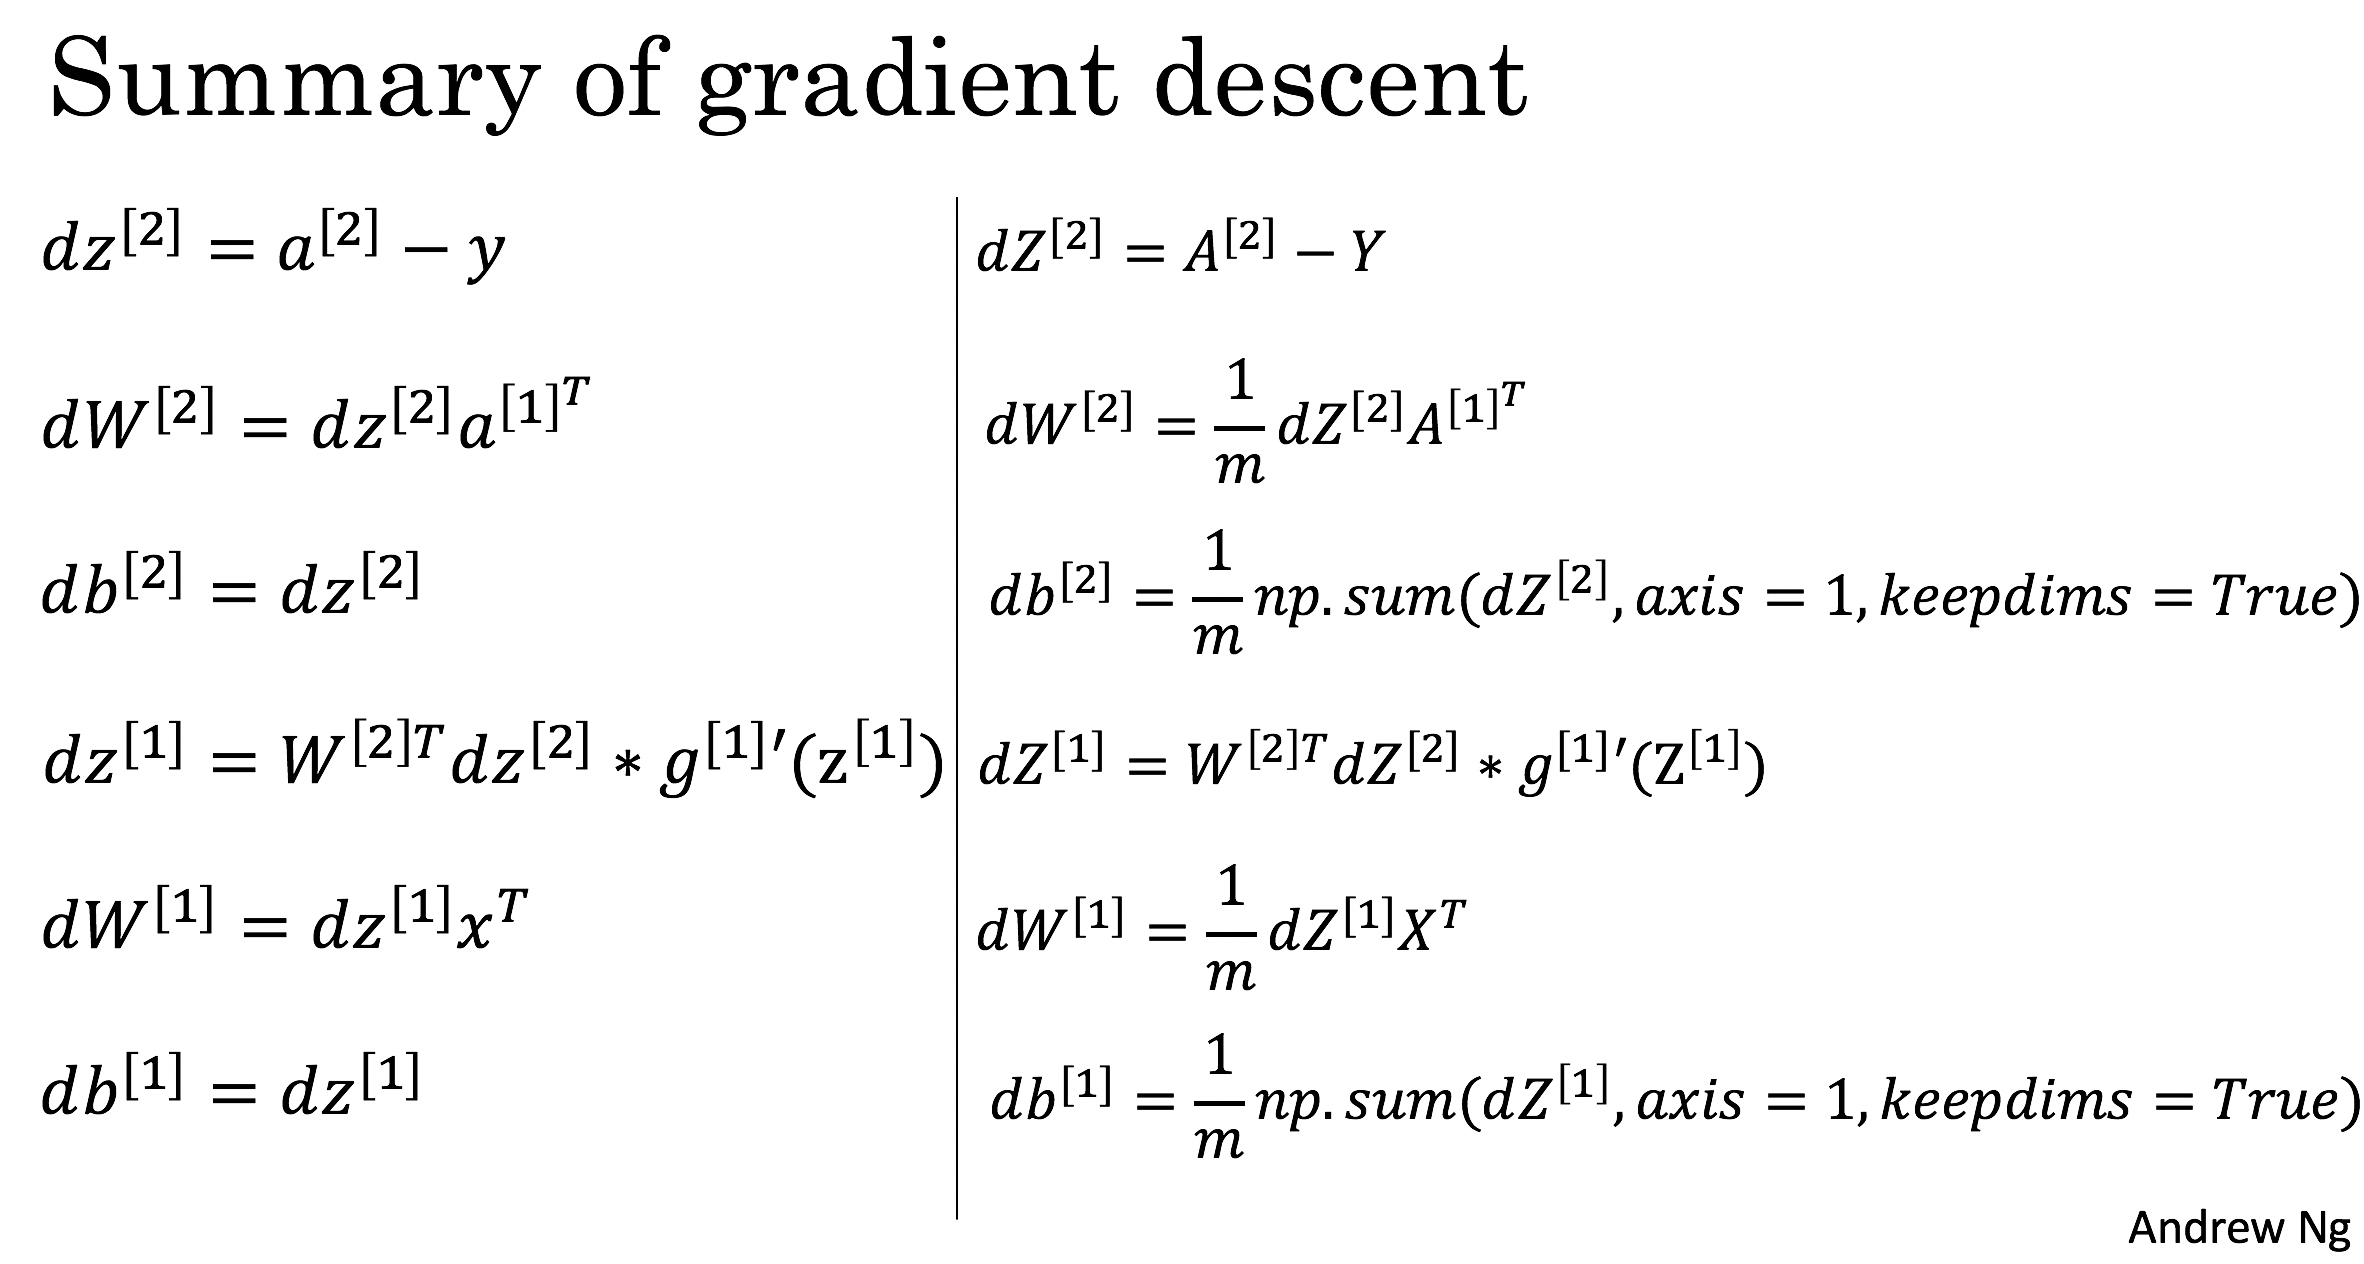

    Figure 1: Backpropagation. Use the six equations on the right.

**Tips:**

To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$.

Since $g^{[1]}(.)$ is the tanh activation function, if a = $g^{[1]}(z)$ then $g^{[1]'}(Z^{[1]}) = 1 - a^2$.

So you can compute using (1 - np.power(A1, 2)).

In [319]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    #     w1 = 4, 2
    #     b1 = 4, 1
    #     x = 2, m
    #     z1 = 4, m
    #     a1 = 4, m
    #     w2 = 1, 4
    #     b2 = 1, 1
    #     z2 = 1, m
    #     a2 = 1, m
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * ((1 - np.power(A1, 2)))      # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [171]:
#test the backward_propagation
def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess

parameters, cache, t_X, t_Y = backward_propagation_test_case()
grads = backward_propagation(parameters, cache, t_X, t_Y)

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


#### 4.6 - Update Parameters

##### Exercise 7 - update_parameters
    Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

        General gradient descent rule: θ = θ - α dJ/dθ
 
     where α is the learning rate and θ represents a parameter.
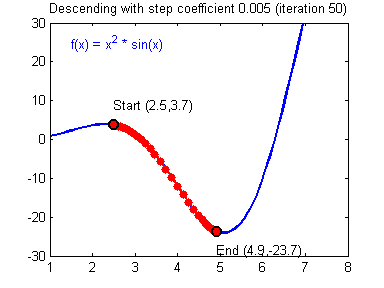

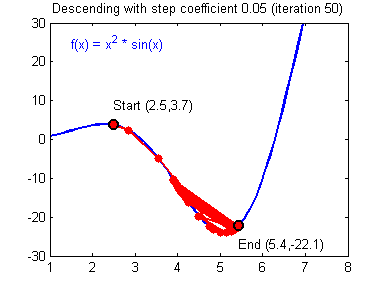

    Figure 2: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

**Hint**
    
    Use copy.deepcopy(...) when copying lists or dictionaries that are passed as parameters to functions. 
    
    It avoids input parameters being modified within the function. 
    
    In some scenarios, this could be inefficient, but it is required for grading purposes.

In [320]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [174]:
#test the update_parameters() function
def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
                  'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
                  'b1': np.array([[ -8.97523455e-07], [8.15562092e-06], [6.04810633e-07], [ -2.54560700e-06]]),
                  'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
             'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
             'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
             'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads

parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


#### 4.7 - Integration
    Integrate your functions in nn_model()


##### Exercise 8 - nn_model
    Build your neural network model in nn_model().

    Instructions: The neural network model has to use the previous functions in the right order.

In [321]:
def nn_model(X, y, n_h, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
     
    n_x = layer_sizes(X, y)[0]
    n_y = layer_sizes(X, y)[2]
    n_h = n_h
    
    params = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, params)
        cost = compute_cost(A2, y)
        grads = backward_propagation(params, cache, X, y)
        params = update_parameters(params, grads)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return params
    

In [183]:
#test the model
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    return X_assess, Y_assess

t_X, t_Y = nn_model_test_case()
params = nn_model(t_X, t_Y, n_h=4, num_iterations=10000, print_cost=True)
print(params)

Cost after iteration 0: 0.693198
Cost after iteration 1000: 0.000219
Cost after iteration 2000: 0.000108
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
{'W1': array([[ 0.56305445, -1.03925886],
       [ 0.7345426 , -1.36286875],
       [-0.72533346,  1.33753027],
       [ 0.74757629, -1.38274074]]), 'b1': array([[-0.22240654],
       [-0.34662093],
       [ 0.33663708],
       [-0.35296113]]), 'W2': array([[ 1.82196893,  3.09657075, -2.98193564,  3.19946508]]), 'b2': array([[0.21344644]])}


### 5 - Test the Model

#### 5.1 - Predict

##### Exercise 9 - predict
    Predict with your model by building predict(). Note, here we use forward propagation to predict results.
    
    Note: predictions are calculated after finding the final params. During forward prop and cost, activations only used

    Reminder:
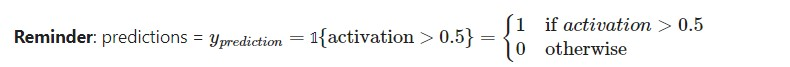

    As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: X_new = (X > threshold)

In [322]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    y_pred = (A2 > 0.5)
    return y_pred

In [188]:
#test the predict() function
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess

parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))

Predictions: [[ True False  True]]


### 5.2 - Now Test the Model on the Planar Dataset
    It's time to run our model and see how it performs on our planar/flower dataset. Run the following code to test your model with a single hidden layer of n_h hidden units!

In [199]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, y, n_h=4, num_iterations=10000, print_cost=True)

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220641
Cost after iteration 8000: 0.219419
Cost after iteration 9000: 0.218528


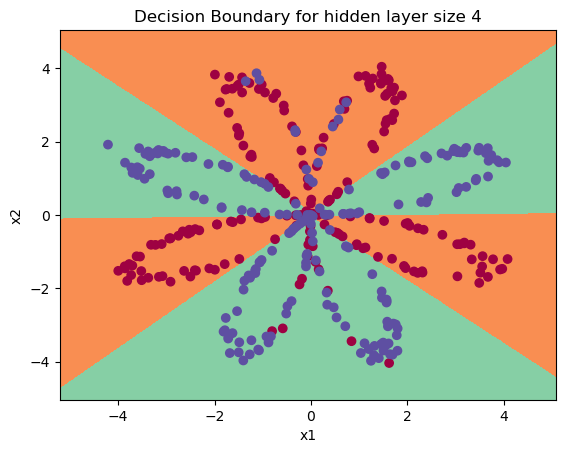

In [217]:
# Plot the decision boundary
nn_model_predict = lambda x: predict(parameters, x.T) #transpose cuz in plot decision boundary, we will have (m, n) kind of shape
plot_decision_boundary(nn_model_predict, X, y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

In [215]:
# Print Training accuracy
y_preds = predict(parameters, X)
# print(1 * False) 
# print(1 * True) #note: boolean value * 1 or boolean value * 0 is possible and be treated True as 1, False as 0
#print(y.size) #400 which is equal to y.shape[1]
#print(len(y)) #1
print("Training Accuracy: %d" % float(((np.dot(y, y_preds.T) + np.dot(1-y, (1-y_preds).T)) / float(y.size)) * 100) + "%")

Training Accuracy: 90%


    Accuracy is really high compared to Logistic Regression. The model has learned the patterns of the flower's petals! Unlike logistic regression, neural networks are able to learn even highly non-linear decision boundaries.

    Congrats on finishing this Programming Assignment!

    Here's a quick recap of all you just accomplished:

        - Built a complete 2-class classification neural network with a hidden layer
        - Made good use of a non-linear unit
        - Computed the cross entropy loss
        - Implemented forward and backward propagation

    You've created a neural network that can learn patterns! Excellent work. 
    
    Below, there are some optional exercises to try out some other hidden layer sizes, and other datasets.

### 6 - Tuning hidden layer size (optional exercise)
    Lets see the impact of varying the hidden layer size, and how the model overfits the data.

    Run the following code(it may take 1-2 minutes). Then, observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 90.25 %


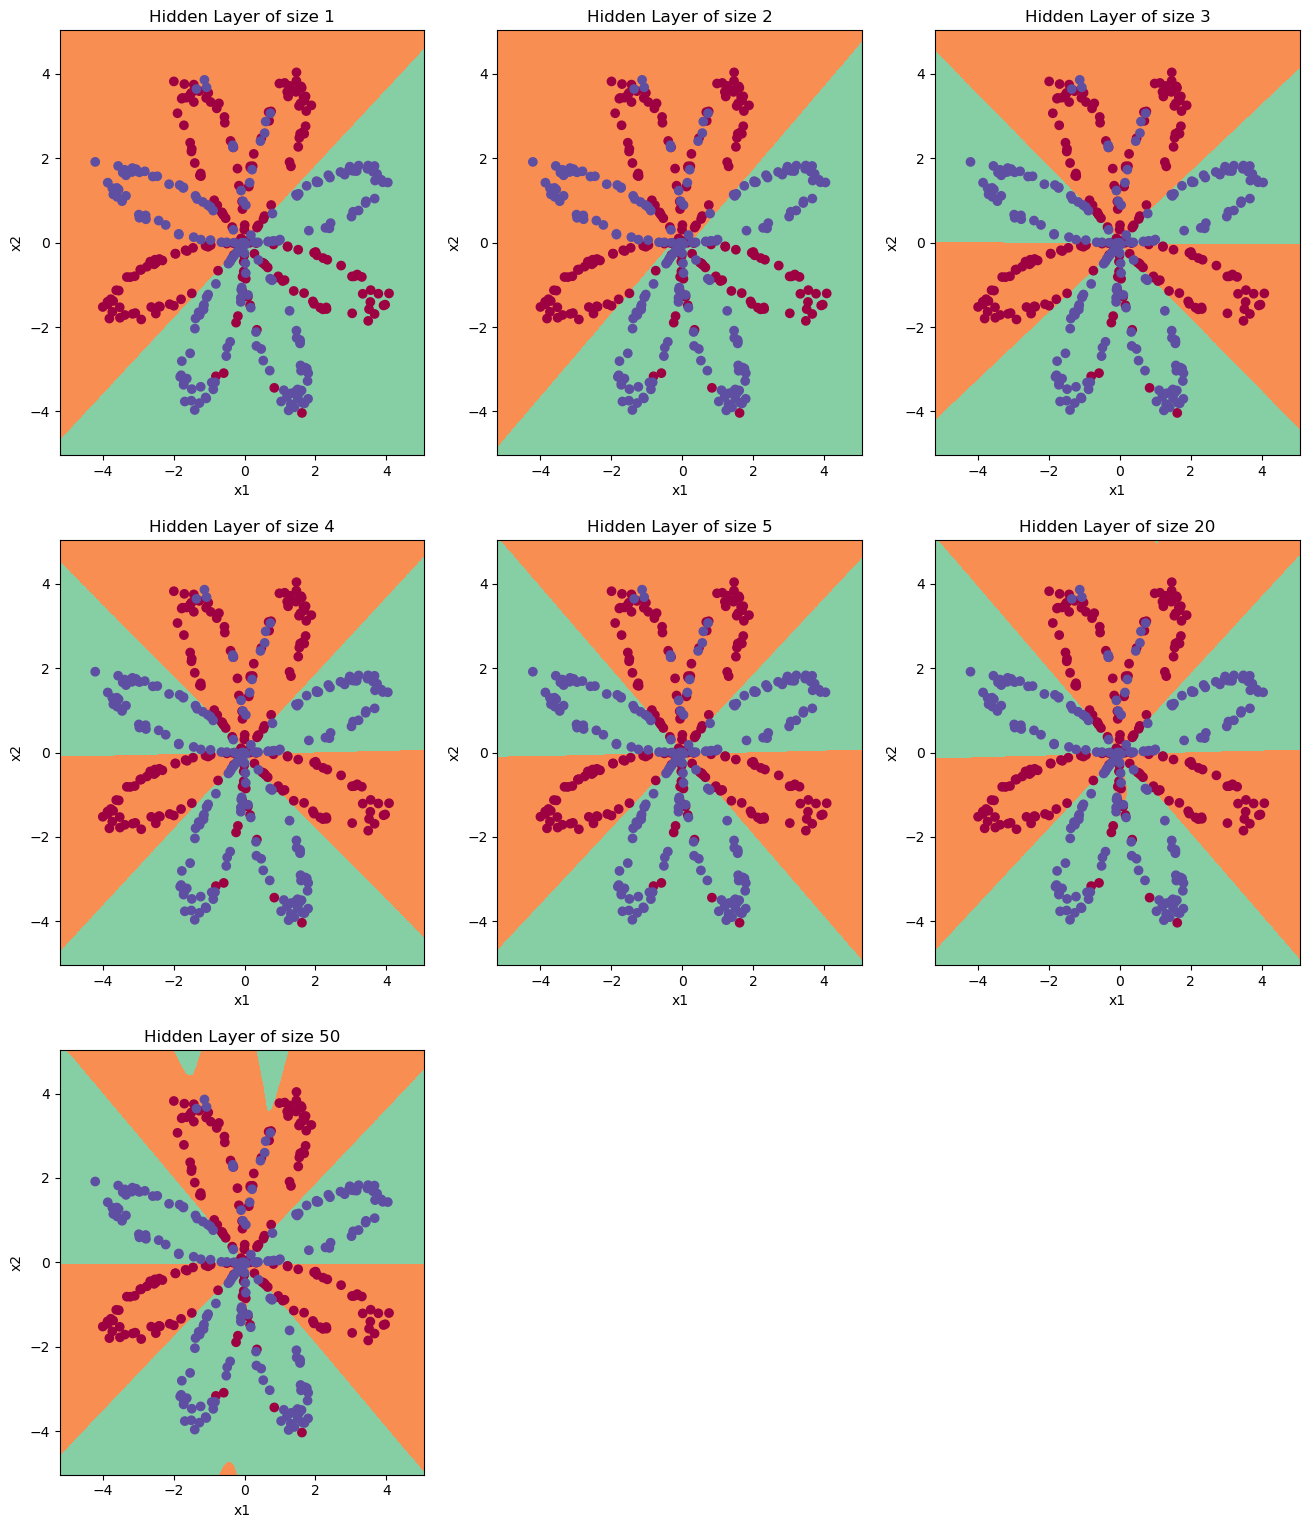

In [223]:
hidden_layers = [1, 2, 3, 4, 5, 20, 50]

plt.figure(figsize=(16, 32))
for i, n_h in enumerate(hidden_layers):
    plt.subplot(5, 3, i+1)
    plt.title("Hidden Layer of size %d" %n_h)
    params = nn_model(X, y, n_h, num_iterations=5000)
    model_predict = lambda x: predict(params, x.T)
    plot_decision_boundary(model_predict, X, y)
    predictions = predict(params, X)
    accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
plt.show()

In [229]:
# plt.figure(figsize=(16, 32))
# for i, n_h in enumerate(hidden_layers):
#     plt.subplot(5, 3, i+1)
# plt.show()

**Interpretation:**

    The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data.
    The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to fits the data well without also incurring noticeable overfitting.
    
    Later, you'll become familiar with regularization, which lets you use very large models (such as n_h = 50) without much overfitting.
    

    Some optional/ungraded questions that you can explore if you wish:

        What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
        Play with the learning_rate. What happens?
        What if we change the dataset? (See part 7 below!)

### 7- Performance on other datasets
    If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [233]:
from sklearn.datasets import make_blobs, make_circles, make_gaussian_quantiles, make_moons
def load_extra_datasets():
    N = 200
    noisy_circles = make_circles(n_samples=N, factor=0.5, noise=0.3)
    noisy_moons = make_moons(n_samples=N, noise=0.20)
    blobs = make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, random_state=None, shuffle=True)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure
    
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

In [239]:
print(noisy_circles[0].shape)
print(noisy_circles[1].shape)
print(noisy_moons[0].shape)
print(noisy_moons[1].shape)
print(blobs[0].shape)
print(blobs[1].shape)
print(gaussian_quantiles[0].shape)
print(gaussian_quantiles[1].shape)
print(no_structure[0].shape)
print(no_structure[1].shape)

(200, 2)
(200,)
(200, 2)
(200,)
(200, 2)
(200,)
(200, 2)
(200,)
(200, 2)
(200, 2)


[0 1 2 3 4 5]
[0 1]
(200, 2)


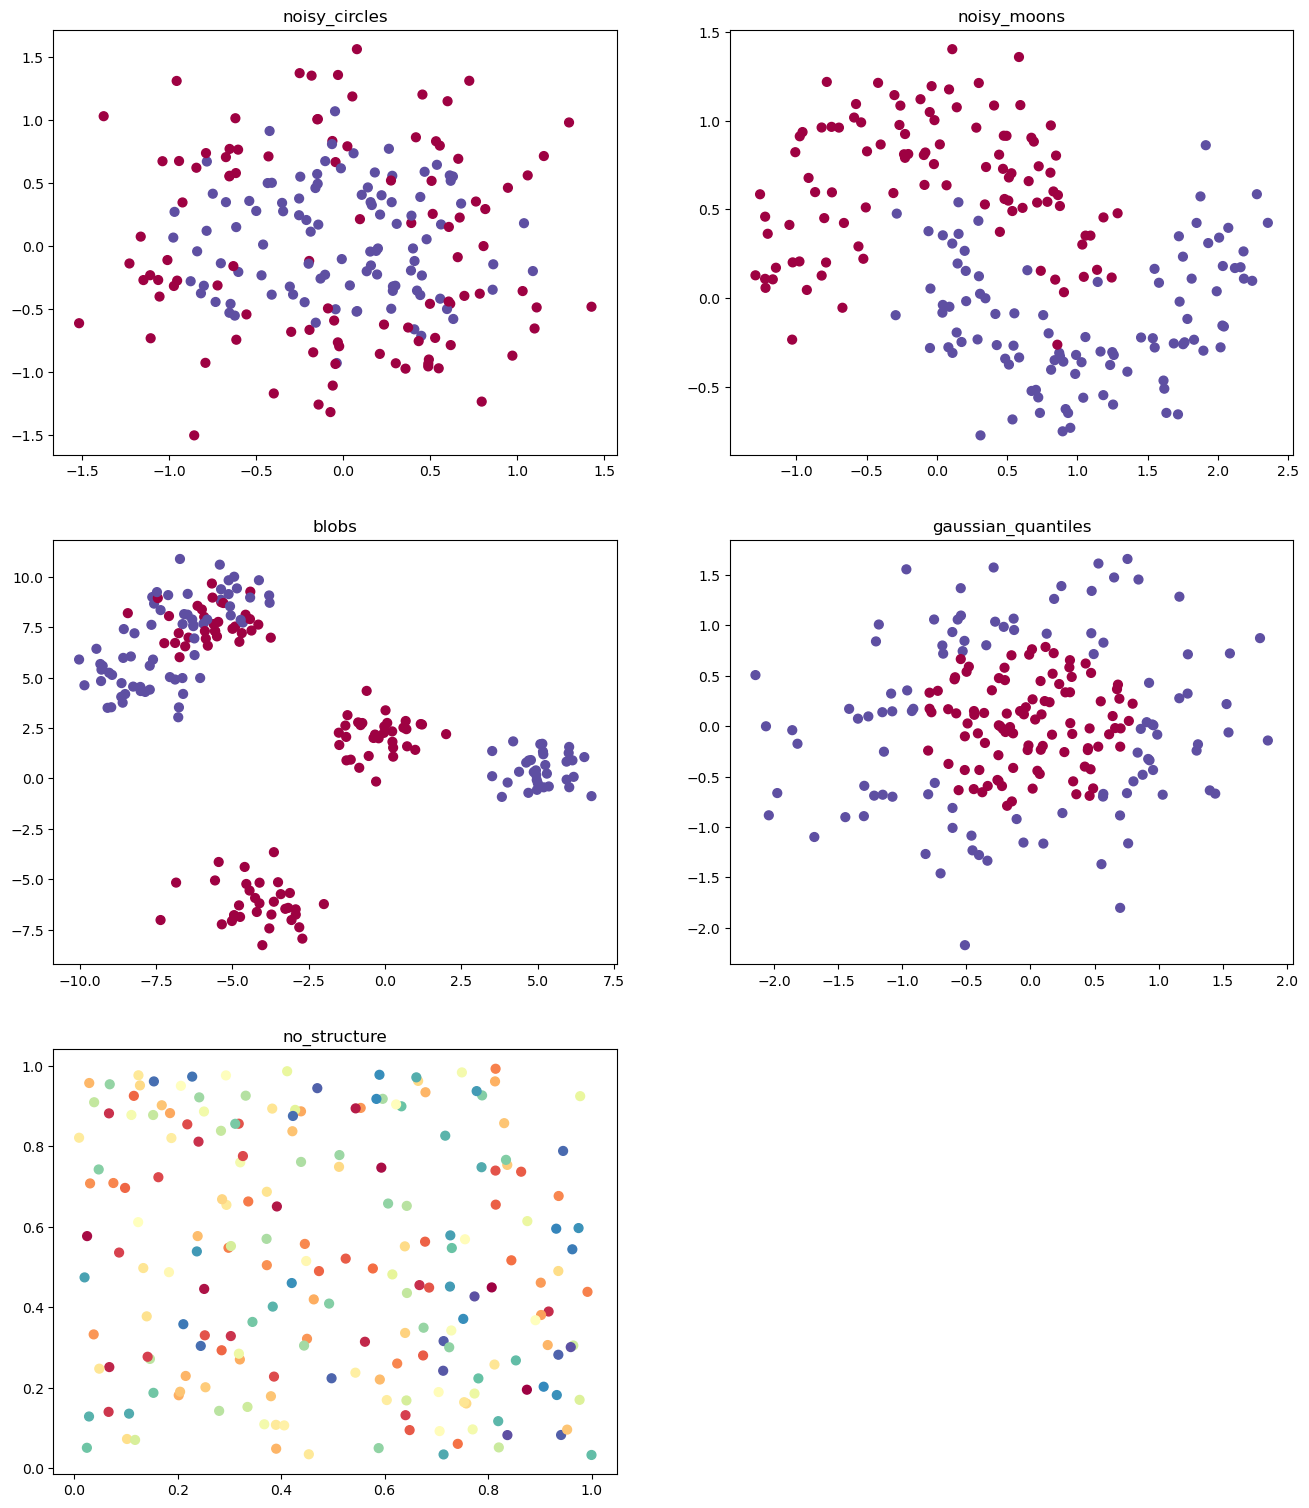

In [261]:
datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles,
            "no_structure" : no_structure
           }

plt.figure(figsize=(16, 32))
for i, (key, dataset) in enumerate(datasets.items()):
    X, y = dataset
    
    # make blobs binary
    if key == "blobs":
        print(np.unique(y))
        y = y % 2 #remainder will be either 0 or 1
        print(np.unique(y))
    if key == "no_structure":
#         print(y.shape) #200, 2
        #just taking the first column
        y = y[:, 0]
    
    X, y = X.T, y.reshape(1, y.shape[0])
    
    plt.subplot(5, 2, i+1)
    plt.scatter(X[0, :], X[1, :], s=40, c=y, cmap=plt.cm.Spectral) # Visualize the data
    plt.title(f"{key}")
    
plt.show()

Accuracy for 5 hidden units: 83.5 %


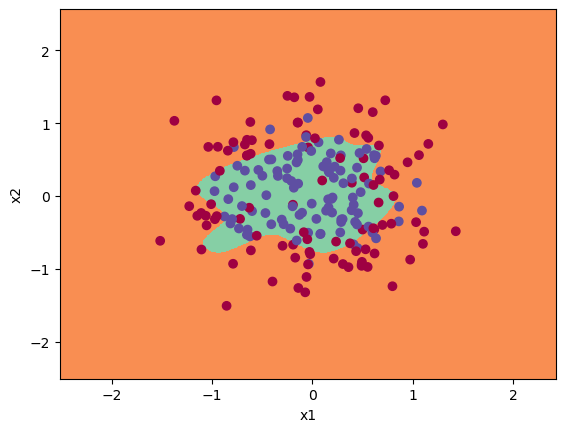

In [268]:
#lets use our neural network on the noisy_circles dataset
dataset = "noisy_circles"

X, y = datasets[dataset]
X, y = X.T, y.reshape(1, y.shape[0])
n_h = 5

params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 1 hidden units: 63.0 %
Accuracy for 2 hidden units: 74.0 %
Accuracy for 3 hidden units: 78.5 %
Accuracy for 4 hidden units: 77.5 %
Accuracy for 5 hidden units: 83.5 %
Accuracy for 20 hidden units: 82.5 %
Accuracy for 50 hidden units: 81.5 %


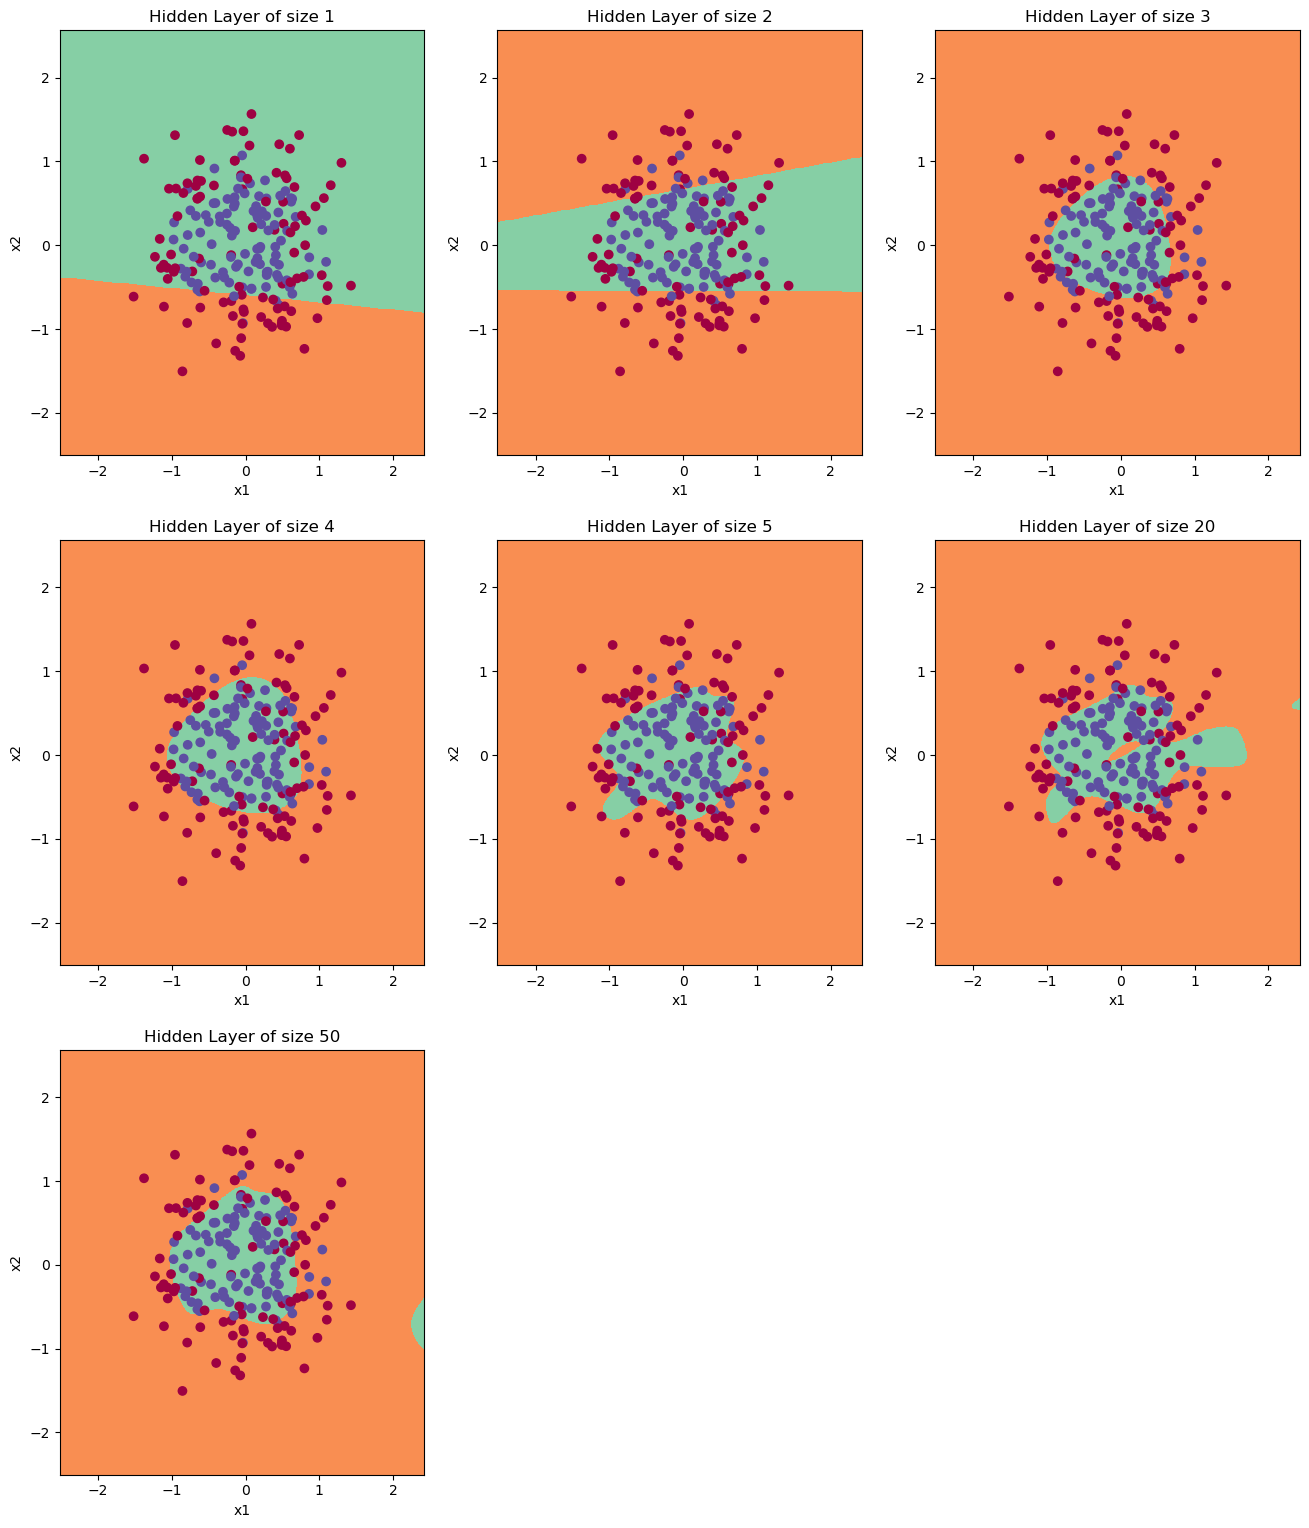

In [323]:
#lets use our neural network on the noisy_circles dataset for different hidden layers
hidden_layers = [1, 2, 3, 4, 5, 20, 50]

plt.figure(figsize=(16, 32))
dataset = "noisy_circles"

X, y = datasets[dataset]
X, y = X.T, y.reshape(1, y.shape[0])

for i, n_h in enumerate(hidden_layers):
    plt.subplot(5, 3, i+1)
    plt.title("Hidden Layer of size %d" %n_h)
    params = nn_model(X, y, n_h, num_iterations=10000)
    model_predict = lambda x: predict(params, x.T)
    plot_decision_boundary(model_predict, X, y)
    predictions = predict(params, X)
    accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
plt.show()

Accuracy for 5 hidden units: 98.5 %


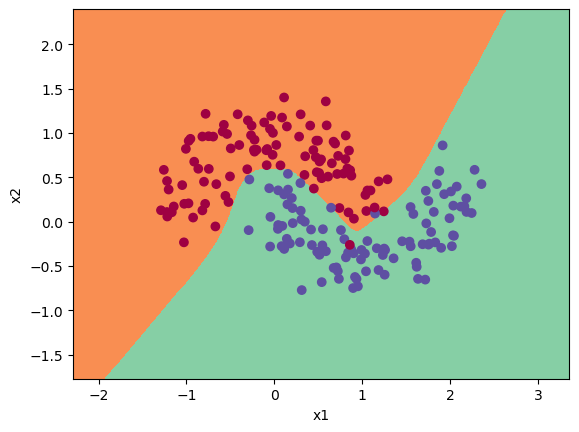

In [269]:
#lets use our neural network on the noisy_moons dataset
dataset = "noisy_moons"

X, y = datasets[dataset]
X, y = X.T, y.reshape(1, y.shape[0])
n_h = 5

params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 5 hidden units: 83.0 %


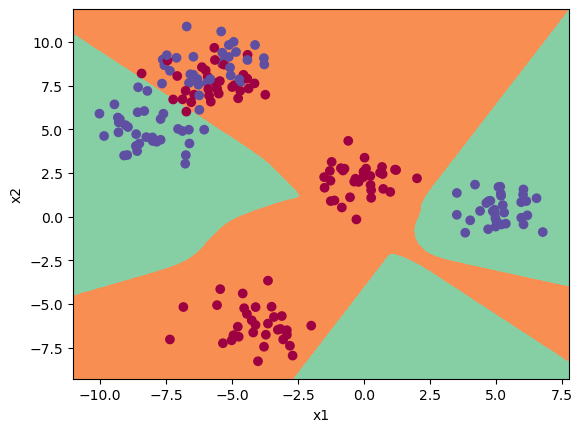

In [272]:
##lets use our neural network on the blobs dataset
dataset = "blobs"

X, y = datasets[dataset]
y = y%2 #making blobs binary
X, y = X.T, y.reshape(1, y.shape[0])

n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

(200, 2)
(200,)
Accuracy for 5 hidden units: 56.765704246144864 %


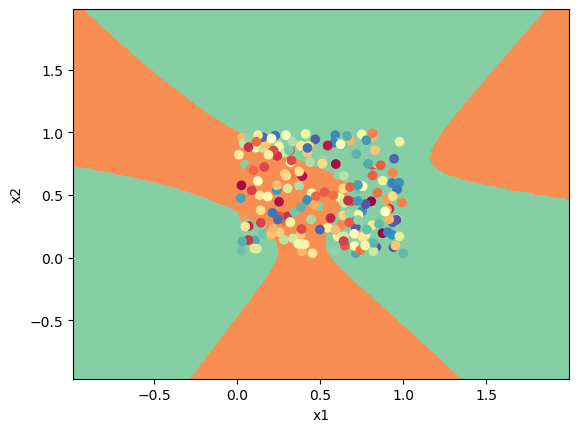

In [278]:
##lets use our neural network on the no_structure dataset
dataset = "no_structure"

X, y = datasets[dataset]
print(y.shape)
y = y[:, 0]
print(y.shape)
X, y = X.T, y.reshape(1, y.shape[0])

n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 5 hidden units: 97.0 %


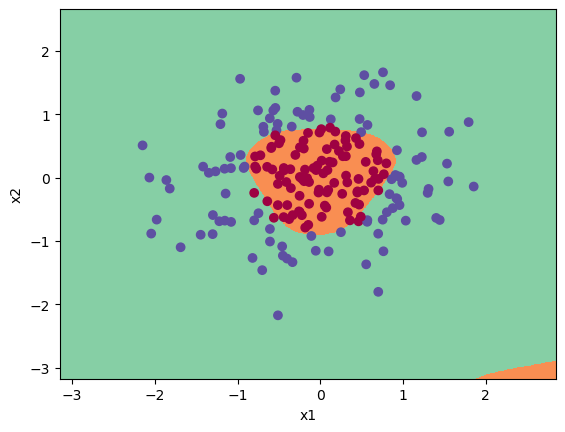

In [270]:
##lets use our neural network on the guassian_quantiles dataset
dataset = "gaussian_quantiles"

X, y = datasets[dataset]
X, y = X.T, y.reshape(1, y.shape[0])
n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

C:\Users\malla\AppData\Local\Temp\ipykernel_25696\3914130827.py:15: RuntimeWarning: divide by zero encountered in log
  logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
C:\Users\malla\AppData\Local\Temp\ipykernel_25696\3914130827.py:15: RuntimeWarning: invalid value encountered in multiply
  logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)


Accuracy for 5 hidden units: 100.0 %


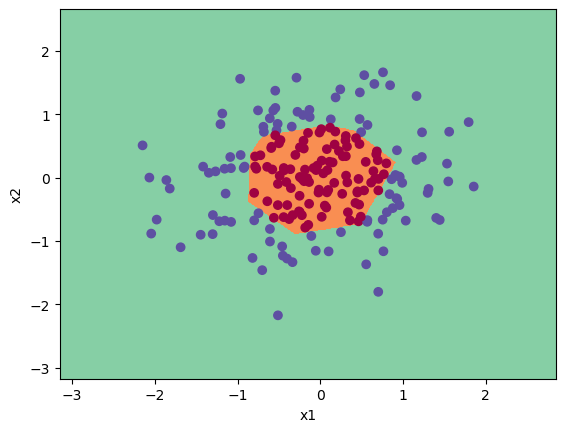

In [310]:
###lets use our neural network on the guassian_quantiles dataset with relu as activation function for hidden layers
def relu(Z):
    g_z = np.maximum(0, Z)
#     g_z = np.where(Z > 0, Z, 0) #we can also use np.where
    return g_z

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = relu(Z1)               #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)            # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    return A2, cache

#The key point to realize is that the activation function does not only affect the forward propagation
#we also need to take it into account in the back propagation process as the hidden layer dW1 uses the derivative of activation function
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * (np.where(Z1>=0, 1, 0))   #relu derivation # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

dataset = "gaussian_quantiles"

X, y = datasets[dataset]
X, y = X.T, y.reshape(1, y.shape[0])
n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 5 hidden units: 89.75 %


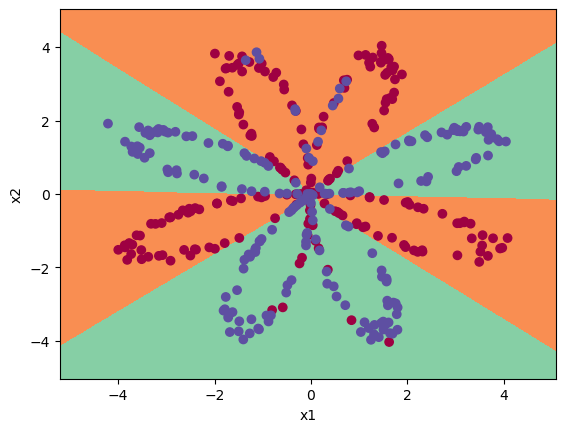

In [294]:
#Trying the original model with sigmoid function as hidden layer activation function instead of tanh

#The key point to realize is that the activation function does not only affect the forward propagation
#we also need to take it into account in the back propagation process as the hidden layer dW1 uses the derivative of activation function

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = sigmoid(Z1)            #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)            # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    
    return A2, cache

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * (A1 * (1 - A1))   #sigmoid derivation # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

X, y = load_planar_dataset()
n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

    Sigmoid layer in the hidden units was able to achieve accuracy of 89.75 with 5 hidden layers and 10000 iterations

Accuracy for 5 hidden units: 61.5 %


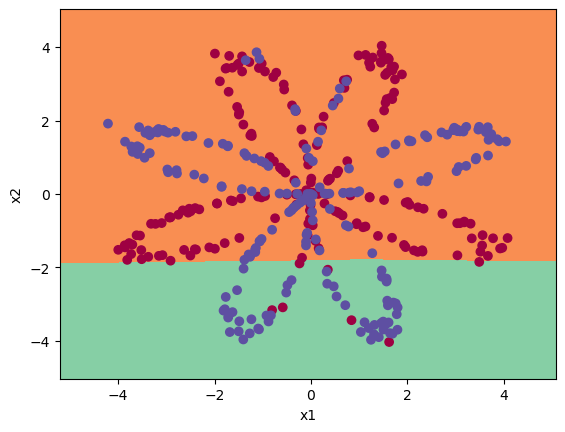

In [307]:
#Trying the original model with relu function as hidden layer activation function instead of tanh
def relu(Z):
    g_z = np.maximum(0, Z)
#     g_z = np.where(Z > 0, Z, 0) #we can also use np.where
    return g_z

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = relu(Z1)               #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)            # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    
    return A2, cache

#The key point to realize is that the activation function does not only affect the forward propagation
#we also need to take it into account in the back propagation process as the hidden layer dW1 uses the derivative of activation function
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * (np.where(Z1>=0, 1, 0))   #relu derivation # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads


X, y = load_planar_dataset()
n_h = 5
params = nn_model(X, y, n_h=5, num_iterations=10000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

    Looks like relu is performing worse when compared to sigmoid. This may be bcuz less number of neurons in the hidden layer. Lets may be increase the hyperparamters like no. of iterations to 12000, hidden layer n_h to 30, learning_rate to 0.05

Accuracy for 30 hidden units: 82.75 %


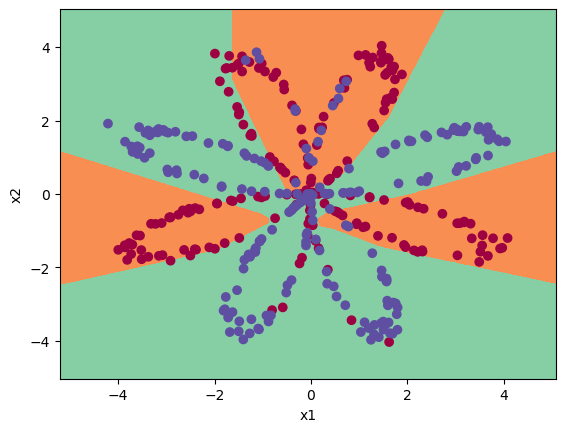

In [308]:
#Trying the original model with relu function as hidden layer activation function instead of tanh
def relu(Z):
    g_z = np.maximum(0, Z)
    return g_z

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = relu(Z1)               #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)            # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    
    return A2, cache

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * (np.where(Z1>=0, 1, 0))   #relu derivation # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate=0.5):
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

X, y = load_planar_dataset()
n_h = 30
params = nn_model(X, y, n_h=30, num_iterations=12000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

     It seems quite a bit easier to get good results using tanh here on this particular problem. 

Accuracy for 30 hidden units: 83.0 %


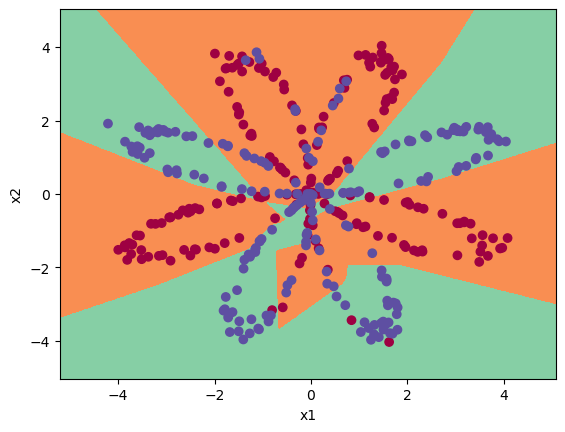

In [309]:
#Trying the original model with leakyrelu function as hidden layer activation function instead of tanh
def leakyrelu(Z):
    g_z = np.maximum(0.01 * Z, Z)
#     g_z = np.where(Z > 0, Z, 0.01*Z) #we can also use np.where
    return g_z

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1     # (n_out, n) (n, m) + (n_out, m) = (n_out, m) 
    A1 = leakyrelu(Z1)          #(n_out, m) => (n_in, m) for layer 2
    Z2 = np.dot(W2 , A1) + b2   #(n_out, n_in) (n_in, m) + (n_out, m) = (n_out, m)
    A2 = sigmoid(Z2)           # (n_out, m)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }
    return A2, cache

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    dZ2 = A2 - Y                                             #(1, m) (1, m) = (1, m) #same as shape of Z2
    dW2 = np.dot(dZ2, A1.T) / m                              #(1, m) (m, 4) = (1, 4) same as shape of W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m             #(1, m) = (1, 1)
    dZ1 = (np.dot(W2.T, dZ2)) * (np.where(Z1>=0, 1, 0.01))   #leakyrelu derivation # (4, 1) (1, m) * (4, m) = (4, m)
    dW1 = np.dot(dZ1,  X.T) / m                              # (4, m) (m, n) = (4, n)
    db1 = np.sum(dZ1, axis=1, keepdims=1) / m                # (4, m) = (4, 1)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate=0.6):
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

X, y = load_planar_dataset()
n_h = 30
params = nn_model(X, y, n_h, num_iterations=20000)
model_predict = lambda x: predict(params, x.T)
plot_decision_boundary(model_predict, X, y)
predictions = predict(params, X)
accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

    Performing good when the learningrate is reduced and the no of hidden units are increase. But tanh seems to be performing well without any of these modifications

In [288]:
#some notes on matrix masking and performing element wise operations
import numpy as np

# Create a sample matrix
matrix = np.array([[0, 2, 0],
                   [4, 0, 6],
                   [0, 8, 0]])

# Assign 1e-1 to elements where the value is 0
mask = matrix == 0
print(mask)
matrix[matrix == 0] = 9

print(matrix)

[[ True False  True]
 [False  True False]
 [ True False  True]]
[[9 2 9]
 [4 9 6]
 [9 8 9]]


### Test cases

In [136]:
def layer_sizes_test(target):
    np.random.seed(1)
    X = np.random.randn(5, 3)
    Y = np.random.randn(2, 3)
    expected_output = (5, 4, 2)
    
    output = target(X, Y)
    
    assert type(output) == tuple, "Output must be a tuple"
    assert output == expected_output, f"Wrong result. Expected {expected_output} got {output}"
    
    X = np.random.randn(7, 5)
    Y = np.random.randn(5, 5)
    expected_output = (7, 4, 5)
    
    output = target(X, Y)
    
    assert type(output) == tuple, "Output must be a tuple"
    assert output == expected_output, f"Wrong result. Expected {expected_output} got {output}"
    
    print("\033[92mAll tests passed!")
    
layer_sizes_test(layer_sizes)

All tests passed!


In [151]:
def initialize_parameters_test(target):
    np.random.seed(2)
    n_x, n_h, n_y = 3, 5, 2

    expected_output = {'W1': np.array(
        [[-0.00416758, -0.00056267, -0.02136196],
         [ 0.01640271, -0.01793436, -0.00841747],
         [ 0.00502881, -0.01245288, -0.01057952],
         [-0.00909008,  0.00551454,  0.02292208],
         [ 0.00041539, -0.01117925,  0.00539058]]), 
                       'b1': np.array([[0.], [0.], [0.], [0.], [0.]]), 
                       'W2': np.array([[-5.96159700e-03, -1.91304965e-04,  1.17500122e-02,
        -7.47870949e-03,  9.02525097e-05],
       [-8.78107893e-03, -1.56434170e-03,  2.56570452e-03,
        -9.88779049e-03, -3.38821966e-03]]), 
                       'b2': np.array([[0.], [0.]])}
    
    parameters = target(n_x, n_h, n_y)
    
    assert type(parameters["W1"]) == np.ndarray, f"Wrong type for W1. Expected: {np.ndarray}"
    assert type(parameters["b1"]) == np.ndarray, f"Wrong type for b1. Expected: {np.ndarray}"
    assert type(parameters["W2"]) == np.ndarray, f"Wrong type for W2. Expected: {np.ndarray}"
    assert type(parameters["b2"]) == np.ndarray, f"Wrong type for b2. Expected: {np.ndarray}"
    
    assert parameters["W1"].shape == expected_output["W1"].shape, f"Wrong shape for W1."
    assert parameters["b1"].shape == expected_output["b1"].shape, f"Wrong shape for b1."
    assert parameters["W2"].shape == expected_output["W2"].shape, f"Wrong shape for W2."
    assert parameters["b2"].shape == expected_output["b2"].shape, f"Wrong shape for b2."
    
    assert np.allclose(parameters["W1"], expected_output["W1"]), "Wrong values for W1"
    assert np.allclose(parameters["b1"], expected_output["b1"]), "Wrong values for b1"
    assert np.allclose(parameters["W2"], expected_output["W2"]), "Wrong values for W2"
    assert np.allclose(parameters["b2"], expected_output["b2"]), "Wrong values for b2"
   
    print("\033[92mAll tests passed!")
    
initialize_parameters_test(initialize_parameters)

All tests passed!


In [161]:
def forward_propagation_test(target):
    np.random.seed(1)
    X = np.random.randn(2, 3)
    b1 = np.random.randn(4, 1)
    b2 = np.array([[ -1.3]]) 

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': b1,
     'b2': b2}
    expected_A1 = np.array([[ 0.9400694 ,  0.94101876,  0.94118266],
                     [-0.67151964, -0.62547205, -0.65709025],
                     [ 0.29034152,  0.31196971,  0.33449821],
                     [-0.22397799, -0.25730819, -0.2197236 ]])
    expected_A2 = np.array([[0.21292656, 0.21274673, 0.21295976]])

    expected_Z1 = np.array([[ 1.7386459 ,  1.74687437,  1.74830797],
                        [-0.81350569, -0.73394355, -0.78767559],
                        [ 0.29893918,  0.32272601,  0.34788465],
                        [-0.2278403 , -0.2632236 , -0.22336567]])

    expected_Z2 = np.array([[-1.30737426, -1.30844761, -1.30717618]])
    expected_cache = {"Z1": expected_Z1,
             "A1": expected_A1,
             "Z2": expected_Z2,
             "A2": expected_A2}
    expected_output = (expected_A2, expected_cache)
    
    output = target(X, parameters)
    
    assert type(output[0]) == np.ndarray, f"Wrong type for A2. Expected: {np.ndarray}"
    assert type(output[1]["Z1"]) == np.ndarray, f"Wrong type for cache['Z1']. Expected: {np.ndarray}"
    assert type(output[1]["A1"]) == np.ndarray, f"Wrong type for cache['A1']. Expected: {np.ndarray}"
    assert type(output[1]["Z2"]) == np.ndarray, f"Wrong type for cache['Z2']. Expected: {np.ndarray}"
    
    assert output[0].shape == expected_A2.shape, f"Wrong shape for A2."
    assert output[1]["Z1"].shape ==expected_Z1.shape, f"Wrong shape for cache['Z1']."
    assert output[1]["A1"].shape == expected_A1.shape, f"Wrong shape for cache['A1']."
    assert output[1]["Z2"].shape == expected_Z2.shape, f"Wrong shape for cache['Z2']."
    
    assert np.allclose(output[0], expected_A2), "Wrong values for A2"
    assert np.allclose(output[1]["Z1"], expected_Z1), "Wrong values for cache['Z1']"
    assert np.allclose(output[1]["A1"], expected_A1), "Wrong values for cache['A1']"
    assert np.allclose(output[1]["Z2"], expected_Z2), "Wrong values for cache['Z2']"
    
    print("\033[92mAll tests passed!")
    
forward_propagation_test(forward_propagation)

All tests passed!


In [162]:
def compute_cost_test(target):
    np.random.seed(1)
    Y_2 = (np.random.randn(1, 5) > 0)
    A2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963, 0.25, 0.7]]))
    
    A3 = np.array([0.7,0.3,0.8, 0.9,0.9])
    a3_Y = np.array([1,0,1,1,1]).reshape(1,5)

    expected_output_1 = 0.5447066599017815
    output_1 = target(A2, Y_2)
    
    expected_output_2 = 0.22944289410146546
    output_2 = target(A3, a3_Y)
    
    assert type(output_1) == float, "Wrong type. Float expected"
    assert np.isclose(output_1, expected_output_1), f"Wrong value. Expected: {expected_output_1} got: {output_1}"
    
    assert type(output_2) == float, "Wrong type. Float expected"
    assert np.isclose(output_2, expected_output_2), f"Wrong value. Expected: {expected_output_2} got: {output_2}"
  
    print("\033[92mAll tests passed!")
    
compute_cost_test(compute_cost)

All tests passed!


In [170]:
def backward_propagation_test(target):
    np.random.seed(1)
    X = np.random.randn(3, 7)
    Y = (np.random.randn(1, 7) > 0)
    parameters = {'W1': np.random.randn(9, 3),
         'W2': np.random.randn(1, 9),
         'b1': np.array([[ 0.], [ 0.], [ 0.], [ 0.], [ 0.], [ 0.], [ 0.], [ 0.], [ 0.]]),
         'b2': np.array([[ 0.]])}

    cache = {'A1': np.random.randn(9, 7),
         'A2': np.random.randn(1, 7),
         'Z1': np.random.randn(9, 7),
         'Z2': np.random.randn(1, 7),}

    
    expected_output = {'dW1': np.array([[-0.24468458, -0.24371232,  0.15959609],
                        [ 0.7370069 , -0.64785999,  0.23669823],
                        [ 0.47936123, -0.01516428,  0.01566728],
                        [ 0.03361075, -0.0930929 ,  0.05581073],
                        [ 0.52445178, -0.03895358,  0.09180612],
                        [-0.17043596,  0.13406378, -0.20952062],
                        [ 0.76144791, -0.41766018,  0.02544078],
                        [ 0.22164791, -0.33081645,  0.19526915],
                        [ 0.25619969, -0.09561825,  0.05679075]]),
                 'db1': np.array([[ 0.1463639 ],
                        [-0.33647992],
                        [-0.51738006],
                        [-0.07780329],
                        [-0.57889514],
                        [ 0.28357278],
                        [-0.39756864],
                        [-0.10510329],
                        [-0.13443244]]),
                 'dW2': np.array([[-0.35768529,  0.22046323, -0.29551566, -0.12202786,  0.18809552,
                          0.13700323,  0.35892872, -0.02220353, -0.03976687]]),
                 'db2': np.array([[-0.78032466]])}
    
    output = target(parameters, cache, X, Y)
    
    assert type(output["dW1"]) == np.ndarray, f"Wrong type for dW1. Expected: {np.ndarray}"
    assert type(output["db1"]) == np.ndarray, f"Wrong type for db1. Expected: {np.ndarray}"
    assert type(output["dW2"]) == np.ndarray, f"Wrong type for dW2. Expected: {np.ndarray}"
    assert type(output["db2"]) == np.ndarray, f"Wrong type for db2. Expected: {np.ndarray}"
    
    assert output["dW1"].shape == expected_output["dW1"].shape, f"Wrong shape for dW1."
    assert output["db1"].shape == expected_output["db1"].shape, f"Wrong shape for db1."
    assert output["dW2"].shape == expected_output["dW2"].shape, f"Wrong shape for dW2."
    assert output["db2"].shape == expected_output["db2"].shape, f"Wrong shape for db2."
    
    assert np.allclose(output["dW1"], expected_output["dW1"]), "Wrong values for dW1"
    assert np.allclose(output["db1"], expected_output["db1"]), "Wrong values for db1"
    assert np.allclose(output["dW2"], expected_output["dW2"]), "Wrong values for dW2"
    assert np.allclose(output["db2"], expected_output["db2"]), "Wrong values for db2"
    
    print("\033[92mAll tests passed!")
    
backward_propagation_test(backward_propagation)

All tests passed!


In [175]:
def update_parameters_test(target):
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    
    expected_W1 = np.array([[-0.00643025,  0.01936718],
        [-0.02410458,  0.03978052],
        [-0.01653973, -0.02096177],
        [ 0.01046864, -0.05990141]])
    expected_b1 = np.array([[-1.02420756e-06],
            [ 1.27373948e-05],
            [ 8.32996807e-07],
            [-3.20136836e-06]])
    expected_W2 = np.array([[-0.01041081, -0.04463285,  0.01758031,  0.04747113]])
    expected_b2 = np.array([[0.00010457]])
    
    expected_output = {"W1": expected_W1,
                  "b1": expected_b1,
                  "W2": expected_W2,
                  "b2": expected_b2}
    
    output = target(parameters, grads)

    assert type(output["W1"]) == np.ndarray, f"Wrong type for W1. Expected: {np.ndarray}"
    assert type(output["b1"]) == np.ndarray, f"Wrong type for b1. Expected: {np.ndarray}"
    assert type(output["W2"]) == np.ndarray, f"Wrong type for W2. Expected: {np.ndarray}"
    assert type(output["b2"]) == np.ndarray, f"Wrong type for b2. Expected: {np.ndarray}"
    
    assert output["W1"].shape == expected_output["W1"].shape, f"Wrong shape for W1."
    assert output["b1"].shape == expected_output["b1"].shape, f"Wrong shape for b1."
    assert output["W2"].shape == expected_output["W2"].shape, f"Wrong shape for W2."
    assert output["b2"].shape == expected_output["b2"].shape, f"Wrong shape for b2."
    
    assert np.allclose(output["W1"], expected_output["W1"]), "Wrong values for W1"
    assert np.allclose(output["b1"], expected_output["b1"]), "Wrong values for b1"
    assert np.allclose(output["W2"], expected_output["W2"]), "Wrong values for W2"
    assert np.allclose(output["b2"], expected_output["b2"]), "Wrong values for b2"
    
    print("\033[92mAll tests passed!")
    
update_parameters_test(update_parameters)

All tests passed!


In [184]:
def nn_model_test(target):
    np.random.seed(1)
    X = np.random.randn(2, 3)
    Y = (np.random.randn(1, 3) > 0)
    n_h = 4
    
    t_X, t_Y = nn_model_test_case()
    parameters = target(t_X, t_Y, n_h, num_iterations=10000, print_cost=True)

    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    
    expected_output = {'W1': np.array([[ 0.56305445, -1.03925886],
                                   [ 0.7345426 , -1.36286875],
                                   [-0.72533346,  1.33753027],
                                   [ 0.74757629, -1.38274074]]), 
                       'b1': np.array([[-0.22240654],
                                   [-0.34662093],
                                   [ 0.33663708],
                                   [-0.35296113]]), 
                       'W2': np.array([[ 1.82196893,  3.09657075, -2.98193564,  3.19946508]]), 
                       'b2': np.array([[0.21344644]])}
    
    np.random.seed(3)
    output = target(X, Y, n_h, print_cost=False)
    
    assert type(output["W1"]) == np.ndarray, f"Wrong type for W1. Expected: {np.ndarray}"
    assert type(output["b1"]) == np.ndarray, f"Wrong type for b1. Expected: {np.ndarray}"
    assert type(output["W2"]) == np.ndarray, f"Wrong type for W2. Expected: {np.ndarray}"
    assert type(output["b2"]) == np.ndarray, f"Wrong type for b2. Expected: {np.ndarray}"
    
    assert output["W1"].shape == expected_output["W1"].shape, f"Wrong shape for W1."
    assert output["b1"].shape == expected_output["b1"].shape, f"Wrong shape for b1."
    assert output["W2"].shape == expected_output["W2"].shape, f"Wrong shape for W2."
    assert output["b2"].shape == expected_output["b2"].shape, f"Wrong shape for b2."
    
    assert np.allclose(output["W1"], expected_output["W1"]), "Wrong values for W1"
    assert np.allclose(output["b1"], expected_output["b1"]), "Wrong values for b1"
    assert np.allclose(output["W2"], expected_output["W2"]), "Wrong values for W2"
    assert np.allclose(output["b2"], expected_output["b2"]), "Wrong values for b2"
    
    print("\033[92mAll tests passed!")
    
nn_model_test(nn_model)

Cost after iteration 0: 0.693198
Cost after iteration 1000: 0.000219
Cost after iteration 2000: 0.000108
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.56305445 -1.03925886]
 [ 0.7345426  -1.36286875]
 [-0.72533346  1.33753027]
 [ 0.74757629 -1.38274074]]
b1 = [[-0.22240654]
 [-0.34662093]
 [ 0.33663708]
 [-0.35296113]]
W2 = [[ 1.82196893  3.09657075 -2.98193564  3.19946508]]
b2 = [[0.21344644]]
All tests passed!


In [189]:
def predict_test(target):
    np.random.seed(1)
    X = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    expected_output = np.array([[True, False, True]])
    
    output = target(parameters, X)
    
    assert np.array_equal(output, expected_output), f"Wrong prediction. Expected: {expected_output} got: {output}"
    
    print("\033[92mAll tests passed!")
    
predict_test(predict)

All tests passed!


Iteration 0, Cost 0.693162
Iteration 1000, Cost 0.258625
Iteration 2000, Cost 0.239334
Iteration 3000, Cost 0.230802
Iteration 4000, Cost 0.225528
Iteration 5000, Cost 0.221845
Iteration 6000, Cost 0.219094
Iteration 7000, Cost 0.220602
Iteration 8000, Cost 0.219408
Iteration 9000, Cost 0.218525
Accuracy: 90%


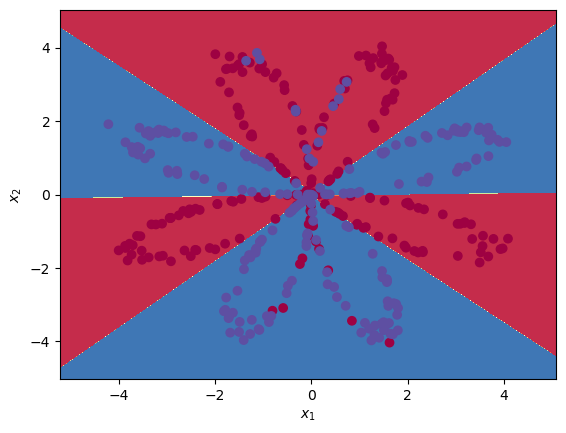

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 91.0 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.0 %
Accuracy for 20 hidden units: 92.25 %
Accuracy for 50 hidden units: 92.0 %


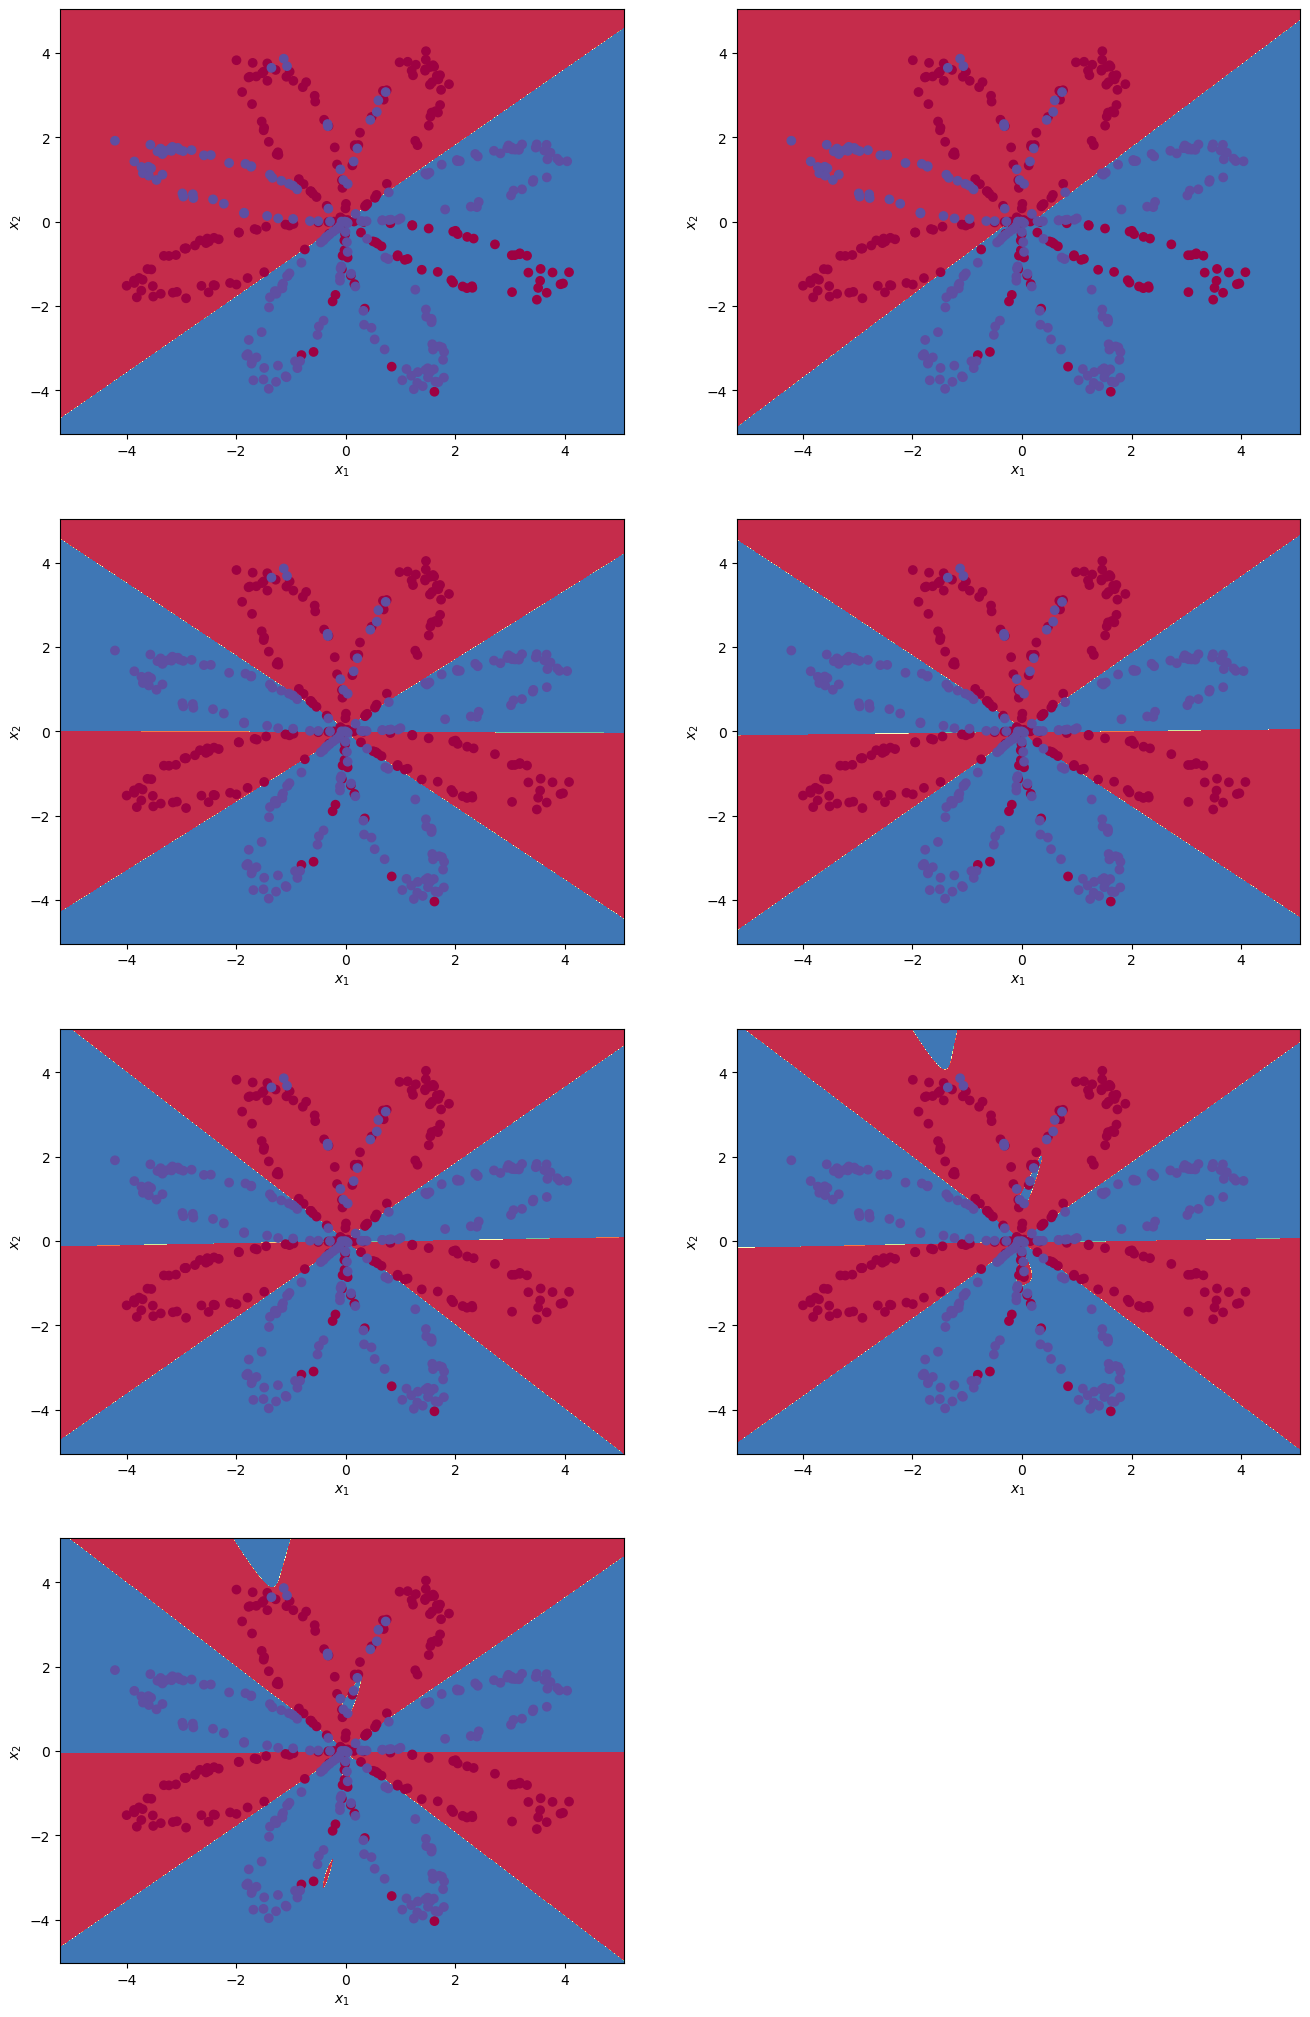

In [418]:
#Self practice
import numpy as np
import matplotlib.pyplot as plt
import copy

def load_data():
    np.random.seed(1)
    m = 400
    n = 2
    classes = 2
    N = int(m/2)
    a = 4
    X = np.zeros((m, n))
    y = np.zeros((m, 1), dtype="uint8")
    for j in range(2):
        idx = range(j*N, (j+1)*N)
        theta = np.linspace(j*3.12, (j+1)*3.12, N) + np.random.randn(N) * 0.2
        radius = a * np.sin(4 * theta) + np.random.randn(N) * 0.2
        X[idx] = np.c_[radius * np.sin(theta), radius * np.cos(theta)]
        y[idx] = j
    X = X.T
    y = y.T
    return(X, y)

def layer_sizes(X, y, h=4):
    n_x = X.shape[0]
    n_y = y.shape[0]
    n_h = h
    return(n_x, n_h, n_y)

def initialize_params(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    init_params = {
        "W1": W1, "b1": b1, "W2" : W2, "b2" : b2
    }
    return init_params

def sigmoid(Z):
    g_Z = 1 / (1 + np.exp(-Z))
    return g_Z

def forward_propagation(X, params):
    W1, b1, W2, b2 = params.values()
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {
        "Z1" : Z1, "A1" : A1, "Z2" : Z2, "A2" : A2
    }
    return A2, cache

def compute_cost(A2, y):
    m = y.shape[1]
    J = np.multiply(y, np.log(A2)) + np.multiply((1-y), np.log(1-A2))
    cost = - np.sum(J) / m #0.69475349
#     J = np.dot(y, np.log(A2.T)) + np.dot(1-y, np.log((1-A2).T))
#     cost = - J / m #[[0.69475349]]
    cost = float(np.squeeze(cost))
    return cost

def backward_propagation(X, y, params, cache):    
    m = X.shape[1]
    W1, b1, W2, b2 = params.values()
    Z1, A1, Z2, A2 = cache.values()

    dZ2 = A2 - y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dW1" : dW1, "db1" : db1, "dW2" : dW2, "db2": db2
    }
    return grads

def optimize_params(params, grads, learning_rate):
    W1, b1, W2, b2 = params.values()
    dW1, db1, dW2, db2 = grads.values()
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    params = {
        "W1": W1, "b1": b1, "W2" : W2, "b2" : b2
    }
    return params
    
def nn_model(X, y, h=4, learning_rate=1.2, num_iters=10000, print_cost=False):
    np.random.seed(3)
    n_x, n_h, n_y = layer_sizes(X, y, h)
    params = initialize_params(n_x, n_h, n_y)
    
    for i in range(0, num_iters):
        A2, cache = forward_propagation(X, params)
        cost = compute_cost(A2, y)
        grads = backward_propagation(X, y, params, cache)
        params = optimize_params(params, grads, learning_rate)
        
        if print_cost and i%1000 == 0:
            print(f"Iteration {i}, Cost {cost:.6f}")
    return params

def predict(params, X):
    A2, _ = forward_propagation(X, params)
    preds = (A2 > 0.5).astype(int)
    return preds

def plot_decision_boundary(X, y, model):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")

X, y = load_data()
params = nn_model(X, y, h=4, learning_rate=1.2, num_iters=10000, print_cost=True)
predictions = predict(params, X)
print ('Accuracy: %d' % float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100) + '%')
model = lambda x: predict(params, x.T)
plot_decision_boundary(X, y, model)
plt.show()

#final hyperparamter tuning
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, h in enumerate(hidden_layer_sizes):
    params = nn_model(X, y, h, learning_rate=1.2, num_iters=10000, print_cost=False)
    model = lambda x: predict(params, x.T)
    plt.subplot(5, 2,  i+1)
    plot_decision_boundary(X, y, model)
    predictions = predict(params, X)
    accuracy = float((np.dot(y, predictions.T) + np.dot(1 - y, 1 - predictions.T)) / float(y.size) * 100)
    print ("Accuracy for {} hidden units: {} %".format(h, accuracy))
plt.show()
    

In [ ]:
np.random.seed(0)
X, y = load_data()
print(str(X.shape) +"" + str(y.shape))
n_h = 4
learning_rate = 1.2
n_x, n_h, n_y = layer_sizes(X, y, n_h)
print(n_x, n_h, n_y)
params = initialize_params(n_x, n_h, n_y)
print(X.shape, params["W1"].shape, params["b1"].shape, params["W2"].shape, params["b2"].shape)
A2, cache = forward_propagation(X, params)
print(A2.shape, cache.keys())
cost = compute_cost(A2, y)
print(cost)
grads = backward_propagation(X, y, params, cache)
print(grads.keys(), grads["dW1"].shape, grads["db1"].shape, grads["dW2"].shape, grads["db2"].shape)
params = optimize_params(params, grads, learning_rate)
print(params["W1"].shape, params["b1"].shape, params["W2"].shape, params["b2"].shape)

assert np.allclose([grads["dW1"].shape, grads["db1"].shape, grads["dW2"].shape, grads["db2"].shape], [params["W1"].shape, params["b1"].shape, params["W2"].shape, params["b2"].shape]), "Something wrong"
plot_decision_boundary(X, y, predict)
plt.show()

#### References:

http://scs.ryerson.ca/~aharley/neural-networks/

http://cs231n.github.io/neural-networks-case-study/